# Auditing an image classification dataset with Datalab

This notebook uses cleanlab's Datalab audit to detect issues in a subset of the famous [Caltech-256 dataset](https://data.caltech.edu/records/nyy15-4j048). cleanlab works with any ML model you've trained on your data and uses outputs from this model to detect issues in your data. Here we just load these pre-computed outputs from file. Please refer to the **train_image_classifier.ipynb** notebook in this same folder, which contains code to train a Swin Transformer model to produce these outputs for our dataset. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cleanlab/examples/blob/master/datalab_image_classification/datalab.ipynb)

## Import necessary libraries and download dataset

In [1]:
from cleanlab import Datalab

import matplotlib.pyplot as plt
import numpy as np
import datasets

Fetch our subset of the Caltech-256 dataset using `wget` to download it from the web, and `tar` to extract the files.

In [2]:
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/Datalab/caltech256-subset.tar.gz'
!mkdir -p data
!tar -xf caltech256-subset.tar.gz -C data/

File ‘caltech256-subset.tar.gz’ already there; not retrieving.



Fetch the pre-computed model outputs for this dataset that cleanlab will rely on. 

In [3]:
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/Datalab/pred_probs_and_features.tar.gz'
!tar -xf pred_probs_and_features.tar.gz -C data/

File ‘pred_probs_and_features.tar.gz’ already there; not retrieving.



We load this dataset using the Hugging Face **datasets** library with the "imagefolder" loader into a `Dataset` object.
The dataset is stored in the ./data/caltech256-subset directory.

In [4]:
dataset_hf = datasets.load_dataset("imagefolder", data_dir="./data/caltech256-subset", split="train")

Resolving data files:   0%|          | 0/635 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /home/vscode/.cache/huggingface/datasets/imagefolder/default-f7d28eea2cd0547e/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


## Visualize the data

Let's look at some random images in the dataset from each of the classes.

080.frog


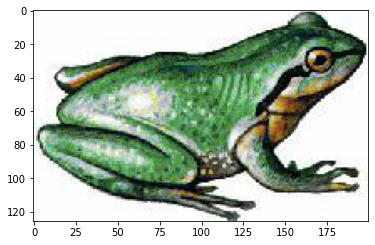

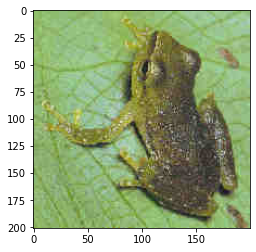

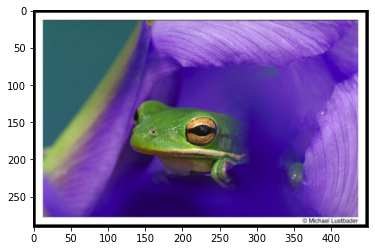

114.ibis-101


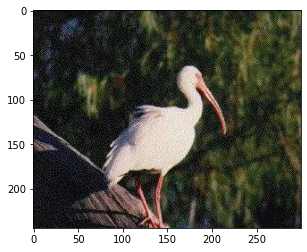

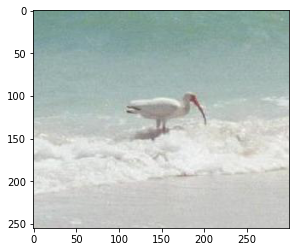

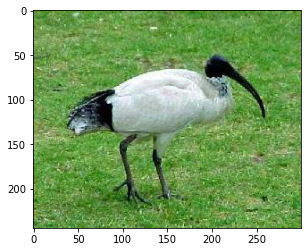

158.penguin


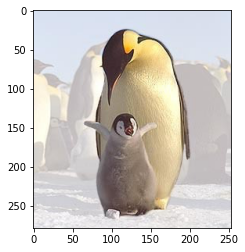

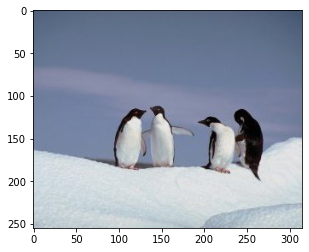

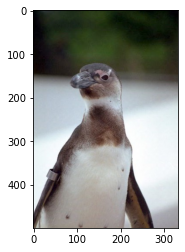

207.swan


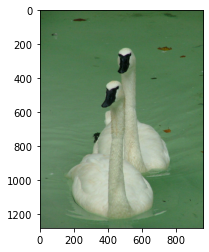

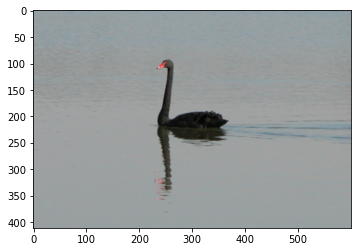

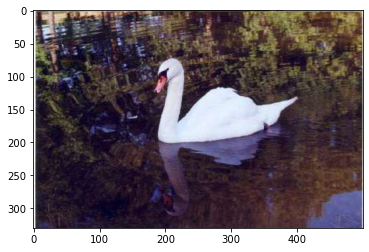

256.toad


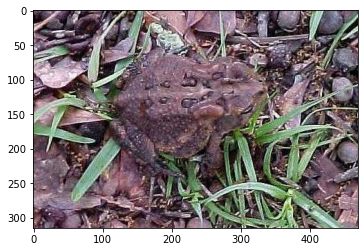

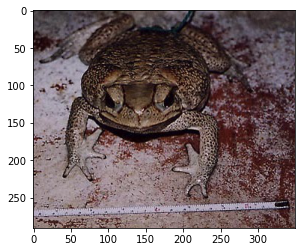

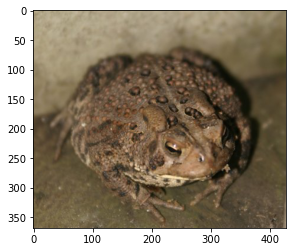

In [5]:
df = dataset_hf.to_pandas()

# Group by label, sample ids from each label
df_group = df.groupby("label").apply(lambda x: x.sample(3))
# Fetch the original ids from the groupby object
ids = df_group.index.get_level_values(1)

def get_image_and_label(idx):
        return dataset_hf[idx]["image"], dataset_hf[idx]["label"]
    
seen_labels = set()
for idx in ids:
    image, label = get_image_and_label(idx)
    if label not in seen_labels:
        print(dataset_hf.features["label"].int2str(label))
    seen_labels.add(label)
    plt.imshow(image)
    plt.show()
    

# Load pre-computed features and predicted probabilities

Next we load the pre-computed outputs from our model; refer to **train_image_classifier.ipynb** to see how they were produced using a Swin Transformer classifier model. We load two arrays: vector feature embeddings and predicted class probabilities for each image in the dataset.
The predicted class probabilities were obtained from a fine-tuned Swin Transformer model with 5-folds cross-validation, 
and the features were generated using the same model trained on the first 4 folds of the dataset.

Note that Datalab can be run with fewer outputs from your model, you do not need to provide both features and predictions. But Datalab can detect more types of issues when provided with more types of outputs from your model. The better your model, the more accurately Datalab can detect data issues.

In [6]:
features = np.load("data/features.npy")
pred_probs = np.load("data/pred_probs.npy")

## Use Datalab to find issues in the dataset

We create a Datalab object with the dataset, specifying the name of the column containing the given label for each image.
We then use the `find_issues` method to audit the quality of the dataset, using the provided feature embeddings and predicted class probabilities.

Finally, we generate a report summarizing the issues detected in this dataset.

In [7]:
lab = Datalab(data=dataset_hf, label_name="label")
lab.find_issues(features=features, pred_probs=pred_probs)

Finding label issues ...
Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Finding near_duplicate issues ...
Audit complete. 50 issues found in the dataset.


In [8]:
lab.report(include_description=False)

Here is a summary of the different kinds of issues found in the data:

    issue_type    score  num_issues
       outlier 0.735523          25
near_duplicate 0.244542          14
         label 0.982677          11

(Note: A lower score indicates a more severe issue across all examples in the dataset.)


---------------------- outlier issues ----------------------

Number of examples with this issue: 25
Overall dataset quality in terms of this issue: : 0.7355

Examples representing most severe instances of this issue:
     is_outlier_issue  outlier_score  nearest_neighbor  distance_to_nearest_neighbor
398              True       0.412073               257                      0.848089
397              True       0.420990               149                      0.845467
633              True       0.425188               396                      0.846003
241              True       0.427850               119                      0.817756
396              True       0.431380               

## Review the different issue types

Here, we retrieve the examples exhibiting different types of issues found in the dataset (label, outlier, and near_duplicate). This allows us to focus on one type of issue at a time.


In [9]:
label_issues, outlier_issues, near_duplicate_issues = (
    lab.get_issues(name) 
    for name in ["label", "outlier", "near_duplicate"]
)

We define a function, `make_image_plot` to visualize images, and provide some context to images that might have issues.

In [10]:
def make_image_plot(ax,img, label=None, additonal_info=None):
    title = ""
    if label is not None:
        title = 'Label {}'.format(label)

    if additonal_info is not None:
        title += '\n' + additonal_info

    if title:
       ax.set_title(title)
    ax.axis("off")
    ax.imshow(img, cmap="gray")


## Visualizing issues

The remainder of this notebook is dedicated to visualizing the different types of issues found in the dataset.

Generally, this involves:

1. Querying one of the `issues` dataframes to find examples that are considered to have an issue or not.

2. Sorting the filtered results by their associated issue quality scores in ascending order.

3. Examining the sorted results and creating subplots of the images with any relevant information or context.

## Near duplicate issues

In this section, we display examples from the dataset that are considered to be nearly duplicated.
The `near_duplicate_issues` DataFrame tells use which examples are considered to have near duplicates, and we can sort them via the `near_duplicate_score` which quantifies how severe this issue is for each image (lower values indicate more severe intances of a type of issue).

This allows us to visualize examples in the dataset that are considered near duplicates, along with their near-duplicate counterparts.

In [11]:
near_duplicate_df = (
    near_duplicate_issues
    .query("is_near_duplicate_issue")
    .sort_values("near_duplicate_score", ascending=True)
)

near_duplicate_df.head(10)

is_near_duplicate_issue  near_duplicate_score near_duplicate_sets  \
116                     True              0.000000               [117]   
117                     True              0.000000               [116]   
244                     True              0.000000               [401]   
399                     True              0.000000               [400]   
400                     True              0.000000               [399]   
401                     True              0.000000               [244]   
520                     True              0.000000               [521]   
521                     True              0.000000               [520]   
410                     True              0.009682               [423]   
423                     True              0.009682               [410]   

     distance_to_nearest_neighbor  
116                      0.000000  
117                      0.000000  
244                      0.000000  
399                      0.000000  
400                      0.000000  
401                      0.000000  
520                      0.000000  
521                      0.000000  
410                      0.009682  
423                      0.009682

We define a `plot_near_duplicate_images` function that takes a row from the `near_duplicate_issues` DataFrame as input. This function:

1. Retrieves the original image and its given label based on the row index.

2. Creates a subplot for the original image and each of its near duplicates.

To avoid cluttering the notebook with the same images, we add some logic for tracking previously displayed images and mainly displaying new images.

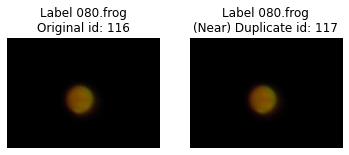

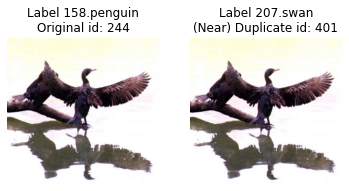

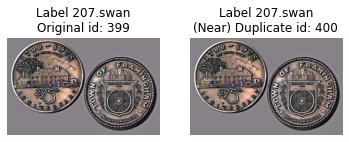

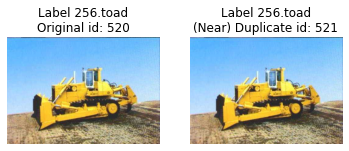

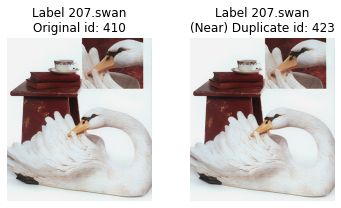

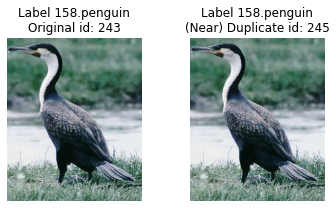

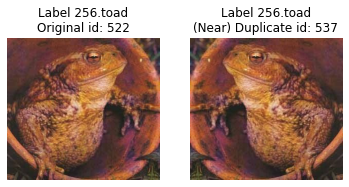

In [12]:
seen_ids = set()

def plot_near_duplicate_images(row):
    def get_image_and_given_label(idx):
        image = dataset_hf[idx]["image"]
        label = label_issues.loc[idx]["given_label"]
        return image, label

    img1_idx = row.name
    if img1_idx in seen_ids:
        return

    duplicate_images = row.near_duplicate_sets
    # how many near duplicates have we seen so far?
    seen_near_duplicates = seen_ids.intersection(duplicate_images)
    # if we have seen all near duplicates, we can skip the rest
    if len(seen_near_duplicates) == len(duplicate_images):
        return
    
    # If the set has more than 5 near duplicates, at least half of them should be new
    if len(duplicate_images) > 5 and len(seen_near_duplicates) > len(duplicate_images) / 2:
        return

    num_figures = len(duplicate_images) + 1
    _, ax = plt.subplots(1, num_figures, figsize=(num_figures * 3, 3))
    original_image, label = get_image_and_given_label(img1_idx)
    make_image_plot(ax[0], original_image, label, additonal_info=f"Original id: {img1_idx}")

    seen_ids.add(img1_idx)
    
    
    for i, duplicate_image in enumerate(duplicate_images):
        img2_idx = int(duplicate_image)
        if True:
            img2, label2 = get_image_and_given_label(img2_idx)
            make_image_plot(ax[i + 1], img2, label2, additonal_info=f"(Near) Duplicate id: {img2_idx}")
            seen_ids.add(img2_idx)

near_duplicate_df.apply(plot_near_duplicate_images, axis=1)
plt.show()

## Label issues


In this section, we focus on visualizing examples in the dataset that have label errors. Label errors occur when the given label for an image is incorrect, usually due to mislabeling during dataset creation. Some of these examples are available at [labelerrors.com](https://labelerrors.com) under the Caltech-256 dataset.

We filter the `label_issues` DataFrame to find examples that are considered to have label errors.

Then, we sort the filtered results by their label quality score in ascending order, where examples with the lowest scores are more likely to have label errors.

In [13]:
labels_df = (
    label_issues
    .query("is_label_issue")
    .sort_values("label_score", ascending=True)
    
)
labels_df.head(10)

is_label_issue  label_score given_label predicted_label
539            True     0.022090    256.toad        080.frog
9              True     0.022368    080.frog        256.toad
44             True     0.025305    080.frog        256.toad
611            True     0.040939    256.toad        080.frog
573            True     0.044906    256.toad        080.frog
632            True     0.049026    256.toad        080.frog
530            True     0.068243    256.toad        080.frog
605            True     0.137757    256.toad        080.frog
596            True     0.158937    256.toad        080.frog
88             True     0.191707    080.frog        256.toad

We define a `plot_label_issues` function to visualize the examples with label errors. This function:

1. Retrieves the image, given label, and predicted label based on the row index.

    - Additionally, we fetch the file name of the image to use as the title of the plot when necessary.

2.  Creates a plot for the image using the `make_image_plot` function with the given label and additional information about the predicted label.

Finally, we apply the `plot_label_issues` function to each row of the filtered and sorted results.

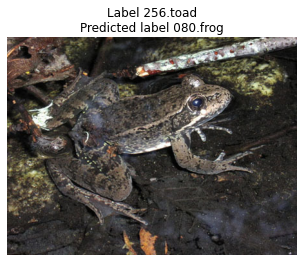

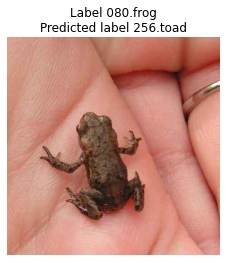

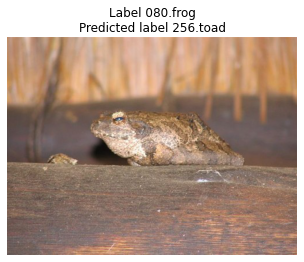

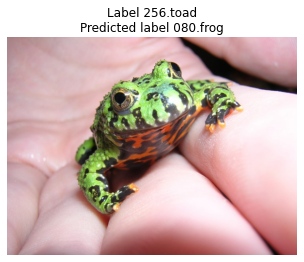

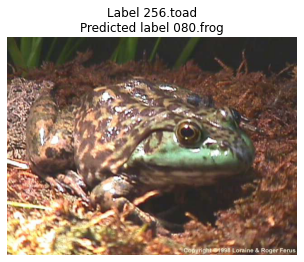

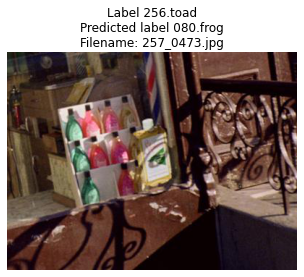

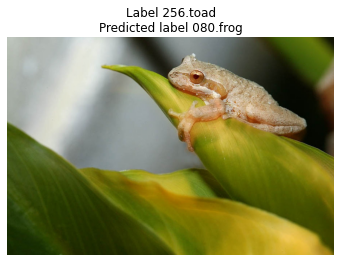

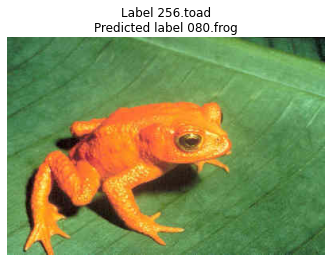

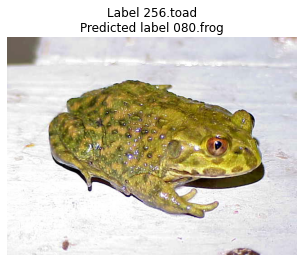

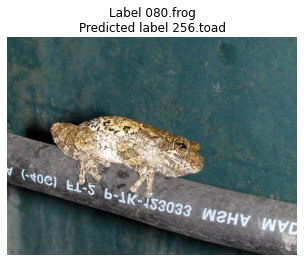

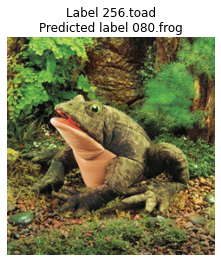

In [14]:
def plot_label_issues(row):
    idx = row.name
    image = dataset_hf[idx]["image"]
    image_filename = image.filename.split("/")[-1]
    label = label_issues.loc[idx]["given_label"]
    predicted_label = label_issues.loc[idx]["predicted_label"]


    filename_label = image_filename.split("_")[0]
    ax = plt.subplot(1, 1, 1)
    additonal_info = f"Predicted label {predicted_label}"
    if label.split(".")[0] != filename_label:
        additonal_info += f"\nFilename: {image_filename}"

    make_image_plot(ax, image, label, additonal_info=additonal_info)
    plt.show()

labels_df.apply(plot_label_issues, axis=1)
plt.show()

Cleanlab reveals a major problem in this dataset is many frogs/toads have been mislabeled as the other class.

## Outlier issues

In this section, we focus on reviewing atypical examples in the dataset. These are examples that are significantly different from the majority of the dataset, which may have an outsized impact on models fit to this data.

Similarly to the previous section, we filter the `outlier_issues` DataFrame to find examples that are considered to be outliers. We then sort the filtered results by their outlier quality score in ascending order, where examples with the lowest scores appear least typical based on the rest of the dataset.

In [15]:
outliers_df = (
    outlier_issues
    .query("is_outlier_issue")
    .sort_values("outlier_score", ascending=True)

)
outliers_df.head(10)

is_outlier_issue  outlier_score  nearest_neighbor  \
398              True       0.412073               257   
397              True       0.420990               149   
633              True       0.425188               396   
241              True       0.427850               119   
396              True       0.431380               395   
630              True       0.434115               395   
632              True       0.449029               519   
519              True       0.449426               517   
119              True       0.449655               634   
518              True       0.455504               634   

     distance_to_nearest_neighbor  
398                      0.848089  
397                      0.845467  
633                      0.846003  
241                      0.817756  
396                      0.734271  
630                      0.807343  
632                      0.754323  
519                      0.720449  
119                      0.626810  
518                      0.667862

To visualize the most anomalous examples, we:

We define a `plot_outlier_issues` function to visualize the examples that are most anomalous. This function:
that takes a row from the `outlier_issues` DataFrame as input. This function:

1. Retrieves the image, given label, nearest neighbor image, and nearest neighbor label based on the row index.

2. Checks if the image has already been displayed as an outlier or as a neighbor of another outlier.

3. Creates a subplot for the original image and its nearest neighbor.

4. Uses the `make_image_plot` function to display the images with additional information about their labels and whether the neighbor is also an outlier.

The `plot_outlier_issues` function is applied to each row of the filtered and sorted results.

By visualizing these anomalous examples and their nearest neighbors, we can gain insights into the dataset's diversity and the potential challenges that these unusual examples may pose during model training and evaluation.

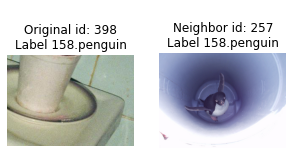

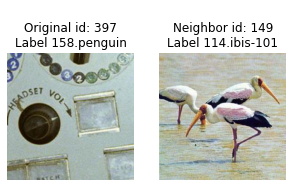

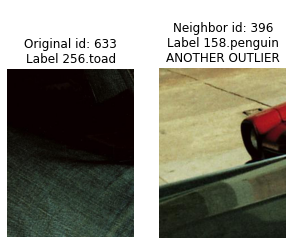

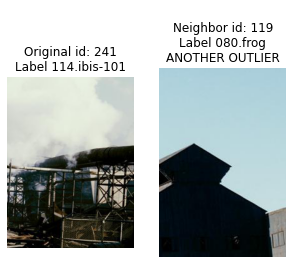

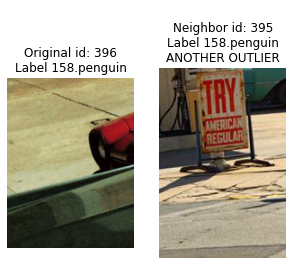

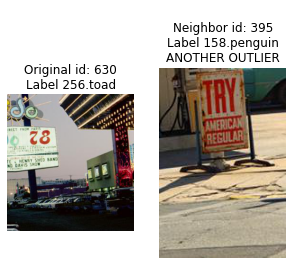

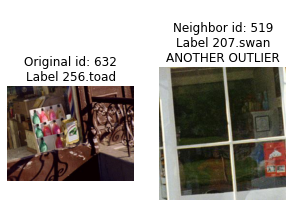

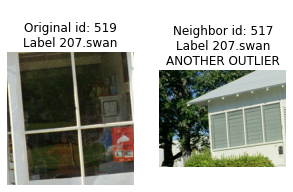

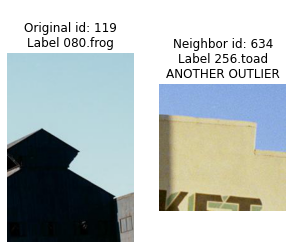

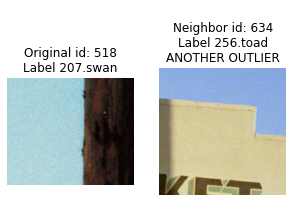

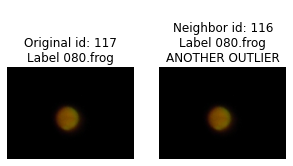

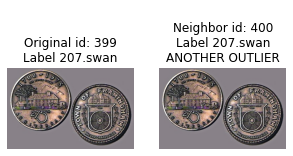

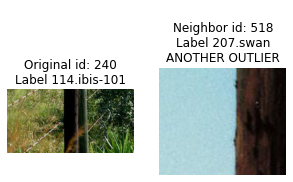

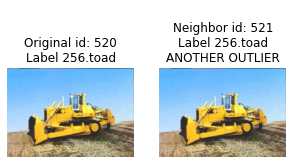

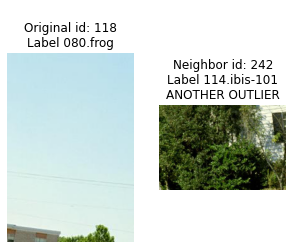

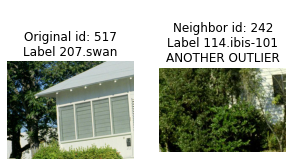

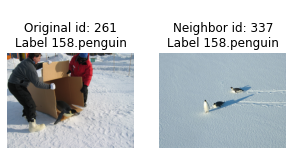

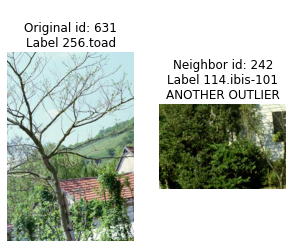

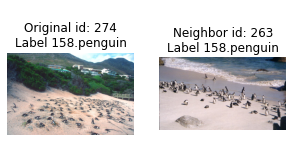

In [16]:
seen_id_pairs = set()

def plot_outlier_issues(row):
    def get_image_given_label_and_neighbor(idx):
        nearest_neighbor_idx = outlier_issues.loc[idx]["nearest_neighbor"]
        is_neighbor_outlier = outlier_issues.loc[nearest_neighbor_idx]["is_outlier_issue"]
        image, neighbor_image = (dataset_hf[int(i)]["image"] for i in (idx, nearest_neighbor_idx))
        label, neighbor_label = (label_issues.loc[i]["given_label"] for i in (idx, nearest_neighbor_idx))
        return image, neighbor_image, label, neighbor_label, nearest_neighbor_idx, is_neighbor_outlier
    
    idx = row.name

    image, neighbor_image, label, neighbor_label, nearest_neighbor_idx, is_neighbor_outlier = get_image_given_label_and_neighbor(idx)

    if (idx, nearest_neighbor_idx) in seen_id_pairs or (nearest_neighbor_idx, idx) in seen_id_pairs:
        return

    _, ax = plt.subplots(1, 2, figsize=(5, 5))


    make_image_plot(ax[0], image, additonal_info=f"Original id: {idx}\nLabel {label}")
    additional_info = f"Neighbor id: {nearest_neighbor_idx}\nLabel {neighbor_label}"
    if is_neighbor_outlier:
        additional_info += "\nANOTHER OUTLIER"
    make_image_plot(ax[1], neighbor_image, additonal_info=additional_info)
    seen_id_pairs.add((idx, nearest_neighbor_idx))
    plt.show()

outliers_df.apply(plot_outlier_issues, axis=1)
plt.show()

Cleanlab reveals this dataset actually contains many miscellaneous images which don't really belong to *any* of the classes for this dataset. Clearly it does not make sense to label such images with this constrained set of classes. 

## Examples that are both near duplicates and inconsistently labeled

In this section, we'll show examples in the dataset that have both near duplicates and label errors.

While the `is_label_error` column in the `label_issues` DataFrame is a more confident indicator of label errors, we use the disagreement between the given label and predicted label instead for demonstration purposes

These examples are particularly interesting because they have issues in multiple aspects and could potentially have a greater impact on model performance.

All we do differently in this section is:

- Filter the *joined* `label_issues` and `near_duplicate_issues` DataFrames to find examples that have both label errors and near duplicates.
   - Note: In the provided code, we use disagreement between the given label and predicted label instead of the `is_label_issue` flag to filter examples with label errors.

Sort the filtered results by their label quality score in ascending order, where examples with the lowest scores are more likely to have label errors.


In [17]:
# query_expr = "is_label_issue and is_near_duplicate_issue"
query_expr = "given_label != predicted_label and is_near_duplicate_issue"  # Use disagreement instead of is_label_issue
near_duplicate_labels_df = (
    label_issues
    .join(near_duplicate_issues, how="outer")
    .query(query_expr)
    .sort_values("label_score", ascending=True)
)
near_duplicate_labels_df.head(10)

is_label_issue  label_score  given_label predicted_label  \
244           False     0.059466  158.penguin        207.swan   
399           False     0.113122     207.swan        080.frog   
400           False     0.113122     207.swan        080.frog   
521           False     0.140555     256.toad        207.swan   

     is_near_duplicate_issue  near_duplicate_score near_duplicate_sets  \
244                     True                   0.0               [401]   
399                     True                   0.0               [400]   
400                     True                   0.0               [399]   
521                     True                   0.0               [520]   

     distance_to_nearest_neighbor  
244                           0.0  
399                           0.0  
400                           0.0  
521                           0.0

We define a `plot_label_and_near_duplicate_issues` function that shows example images that have both issues. This function:

1. Retrieves the image, given label, and predicted label based on the row index.

2. Fetches the near duplicate images.

3. Checks if the image and its near duplicates have already been displayed. This avoids showing identical results multiple times.

4. Creates a subplot for the original image and each of its near duplicates.

The `plot_label_and_near_duplicate_issues` function is applied to each row of the joined, filtered and sorted results.

By visualizing these examples with both label errors and near duplicates, we can better understand the complex relationships between different types of issues in the dataset and their potential impact on model training and evaluation.

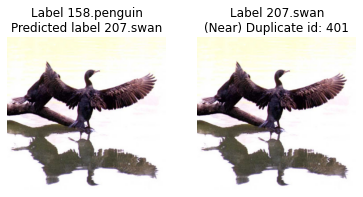

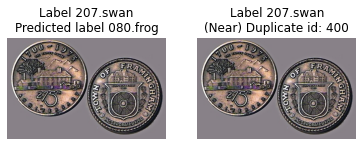

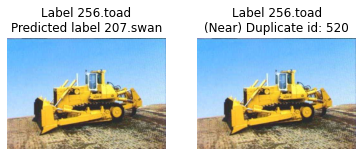

In [18]:
seen_id_pairs = set()
def plot_label_and_near_duplicate_issues(row):
    def get_image_and_given_label_and_predicted_label(idx):
        image = dataset_hf[idx]["image"]
        label = label_issues.loc[idx]["given_label"]
        predicted_label = label_issues.loc[idx]["predicted_label"]
        return image, label, predicted_label

    idx = row.name
    image, label, predicted_label= get_image_and_given_label_and_predicted_label(idx)
    duplicate_images = row.near_duplicate_sets

    id_collection = tuple(sorted([idx] + list(duplicate_images)))
    if id_collection in seen_id_pairs:
        return
    _, ax = plt.subplots(1, len(duplicate_images) + 1, figsize=((len(duplicate_images)+1.5)**2, 3))
    make_image_plot(ax[0], image, label, additonal_info=f"Predicted label {predicted_label}")
    for i, duplicate_image in enumerate(duplicate_images):

        img2, label2, predicted_label2 = get_image_and_given_label_and_predicted_label(int(duplicate_image))
        if (idx, duplicate_image) in seen_id_pairs or (duplicate_image, idx) in seen_id_pairs:
            continue
        seen_id_pairs.add((idx, duplicate_image))
        make_image_plot(ax[i + 1], img2, label2, additonal_info=f"(Near) Duplicate id: {duplicate_image}")
    seen_id_pairs.add(id_collection)

near_duplicate_labels_df.apply(plot_label_and_near_duplicate_issues, axis=1)
plt.show()

Using Datalab to audit your dataset is super easy! If it detects meaningful issues, consider how to fix them, or whether you want to remove certain examples from the dataset entirely. These decisions are important for you to  effectively model your data, but you first need to know what types of issues are lurking in the dataset. 